<a href="https://colab.research.google.com/github/UditanshSri/RLTradingAgent/blob/main/notebooks/multiple_stock_trading_agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
import os
import sys
! python --version
sys.version

Python 3.11.11


'3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]'

In [ ]:
# ! sudo apt-get install swig
# ! pip install box2d-py
# ! pip install stable_baselines3

In [ ]:
! pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

  Cloning https://github.com/AI4Finance-Foundation/FinRL.git to /tmp/pip-req-build-1s0uuykt
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/FinRL.git /tmp/pip-req-build-1s0uuykt
  Resolved https://github.com/AI4Finance-Foundation/FinRL.git to commit 3a10805389c07e13e94333e94dcfe9beafce49b0
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-g3oakpeo/elegantrl_5b79d6a75ec745a3a4b4b2af70df5486
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-install-g3oakpeo/elegantrl_5b79d6a75ec745a3a4b4b2af70df5486
  Resolved https://github.com/AI4Finance-Foundation/ElegantRL.git to commit 2fa34dd9236498beada8d8443d927970a9de1f7f
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.7/

In [ ]:
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader

tickers = ["AAPL", "GOOGL", "MSFT"]
benchmark_ticker = "^GSPC" # S&P 500
start_date = "2015-01-01"
end_date = "2025-01-01"

df_s = YahooDownloader(start_date=start_date, end_date=end_date, ticker_list=tickers).fetch_data()
df_benchmark = YahooDownloader(start_date=start_date, end_date=end_date, ticker_list=[benchmark_ticker]).fetch_data()

df = pd.merge(df_s, df_benchmark[['date', 'close']], on='date', suffixes=('', '_benchmark'))

df

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (7548, 8)
Shape of DataFrame:  (2516, 8)


Price,date,close,high,low,open,volume,tic,day,close_benchmark
0,2015-01-02,24.347168,27.860001,26.837500,27.847500,212818400,AAPL,4,2058.199951
1,2015-01-02,26.381865,26.790001,26.393999,26.629999,26480000,GOOGL,4,2058.199951
2,2015-01-02,40.152485,47.419998,46.540001,46.660000,27913900,MSFT,4,2058.199951
3,2015-01-05,23.661274,27.162500,26.352501,27.072500,257142000,AAPL,0,2020.579956
4,2015-01-05,25.879185,26.399500,25.887501,26.357500,41182000,GOOGL,0,2020.579956
...,...,...,...,...,...,...,...,...,...
7543,2024-12-30,191.240005,192.550003,189.119995,189.800003,14264700,GOOGL,0,5906.939941
7544,2024-12-30,424.829987,427.549988,421.899994,426.059998,13158700,MSFT,0,5906.939941
7545,2024-12-31,250.419998,253.279999,249.429993,252.440002,39480700,AAPL,1,5881.629883
7546,2024-12-31,189.300003,191.960007,188.509995,191.080002,17466900,GOOGL,1,5881.629883


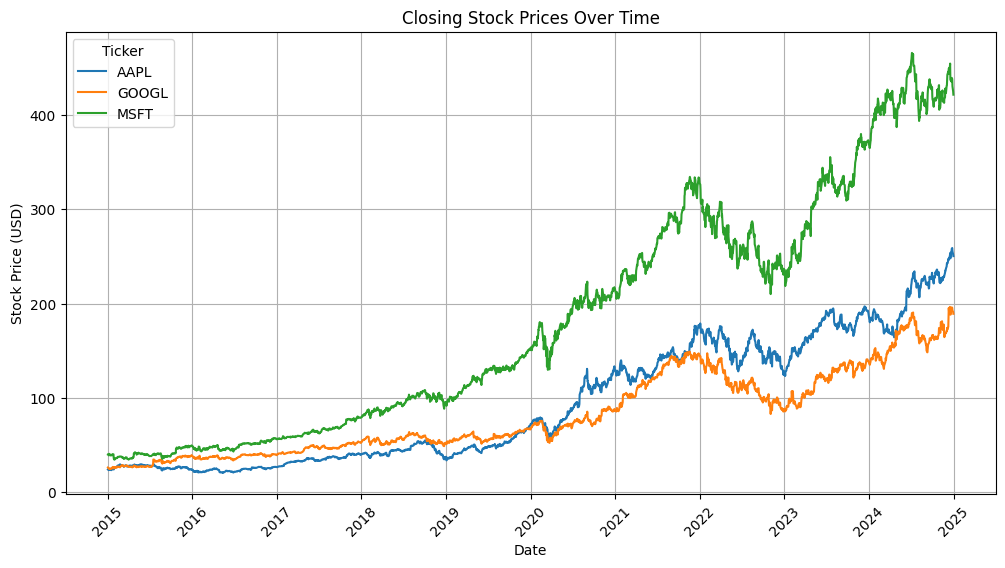

In [ ]:
%matplotlib inline
plt.figure(figsize=(12, 6))

for tic in df['tic'].unique():
    sns.lineplot(x=pd.to_datetime(df[df['tic'] == tic]['date']),
                 y=df[df['tic'] == tic]["close"],
                 label=tic)

plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")
plt.title("Closing Stock Prices Over Time")
plt.xticks(rotation=45)
plt.legend(title="Ticker")
plt.grid()
plt.show()


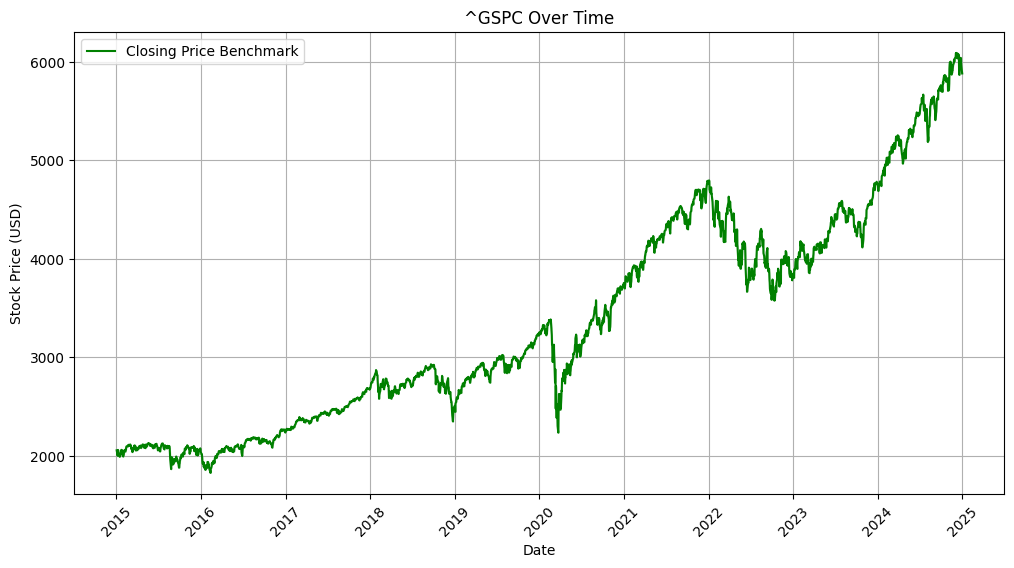

In [ ]:
# Plot benchmark data over time
%matplotlib inline
plt.figure(figsize=(12, 6))
sns.lineplot(x=pd.to_datetime(df['date']), y=df["close_benchmark"], label="Closing Price Benchmark", color="green")
plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")
plt.title(f"{benchmark_ticker} Over Time")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

In [ ]:
from finrl.config import INDICATORS
from finrl.meta.preprocessor.preprocessors import FeatureEngineer

fe = FeatureEngineer(
    use_technical_indicator=True,
    tech_indicator_list=INDICATORS,
    use_turbulence=True
)
df = fe.preprocess_data(df)

df

Successfully added technical indicators
Successfully added turbulence index


,date,close,high,low,open,volume,tic,day,close_benchmark,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
0,2015-01-02,24.347168,27.860001,26.837500,27.847500,212818400,AAPL,4,2058.199951,0.000000,24.974222,23.034220,0.000000,-66.666667,100.000000,24.347168,24.347168,0.000000
1,2015-01-02,26.381865,26.790001,26.393999,26.629999,26480000,GOOGL,4,2058.199951,0.000000,24.974222,23.034220,0.000000,-66.666667,100.000000,26.381865,26.381865,0.000000
2,2015-01-02,40.152485,47.419998,46.540001,46.660000,27913900,MSFT,4,2058.199951,0.000000,24.974222,23.034220,0.000000,-66.666667,100.000000,40.152485,40.152485,0.000000
3,2015-01-05,23.661274,27.162500,26.352501,27.072500,257142000,AAPL,0,2020.579956,-0.015389,24.974222,23.034220,0.000000,-66.666667,100.000000,24.004221,24.004221,0.000000
4,2015-01-05,25.879185,26.399500,25.887501,26.357500,41182000,GOOGL,0,2020.579956,-0.011278,26.841421,25.419628,0.000000,-66.666667,100.000000,26.130525,26.130525,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7543,2024-12-30,191.240005,192.550003,189.119995,189.800003,14264700,GOOGL,0,5906.939941,5.372122,205.648824,167.553206,58.499250,62.882698,14.736694,181.309786,175.021371,1.585298
7544,2024-12-30,424.829987,427.549988,421.899994,426.059998,13158700,MSFT,0,5906.939941,1.384540,456.016003,424.591993,47.825761,-49.127246,20.174768,432.996526,425.938539,1.585298
7545,2024-12-31,250.419998,253.279999,249.429993,252.440002,39480700,AAPL,1,5881.629883,5.102378,259.937259,239.681740,59.539910,61.191869,19.017647,243.988666,236.196178,0.623631
7546,2024-12-31,189.300003,191.960007,188.509995,191.080002,17466900,GOOGL,1,5881.629883,4.849337,205.153820,169.848842,57.053763,52.393989,12.915389,181.876702,175.395225,0.623631


In [ ]:
# df["idx"] = df.index // len(df["tic"].unique())
# df = df.set_index(['idx', df.groupby('idx').cumcount()])

# df

date       close        high         low        open     volume  \
idx                                                                             
0    0  2015-01-02   24.347168   27.860001   26.837500   27.847500  212818400   
     1  2015-01-02   26.381865   26.790001   26.393999   26.629999   26480000   
     2  2015-01-02   40.152485   47.419998   46.540001   46.660000   27913900   
1    0  2015-01-05   23.661274   27.162500   26.352501   27.072500  257142000   
     1  2015-01-05   25.879185   26.399500   25.887501   26.357500   41182000   
...            ...         ...         ...         ...         ...        ...   
2514 1  2024-12-30  191.240005  192.550003  189.119995  189.800003   14264700   
     2  2024-12-30  424.829987  427.549988  421.899994  426.059998   13158700   
2515 0  2024-12-31  250.419998  253.279999  249.429993  252.440002   39480700   
     1  2024-12-31  189.300003  191.960007  188.509995  191.080002   17466900   
     2  2024-12-31  421.500000  426.730011  420.660004  426.100006   13246500   

          tic  day  close_benchmark      macd     boll_ub     boll_lb  \
idx                                                                     
0    0   AAPL    4      2058.199951  0.000000   24.974222   23.034220   
     1  GOOGL    4      2058.199951  0.000000   24.974222   23.034220   
     2   MSFT    4      2058.199951  0.000000   24.974222   23.034220   
1    0   AAPL    0      2020.579956 -0.015389   24.974222   23.034220   
     1  GOOGL    0      2020.579956 -0.011278   26.841421   25.419628   
...       ...  ...              ...       ...         ...         ...   
2514 1  GOOGL    0      5906.939941  5.372122  205.648824  167.553206   
     2   MSFT    0      5906.939941  1.384540  456.016003  424.591993   
2515 0   AAPL    1      5881.629883  5.102378  259.937259  239.681740   
     1  GOOGL    1      5881.629883  4.849337  205.153820  169.848842   
     2   MSFT    1      5881.629883  0.104912  457.209833  422.450162   

           rsi_30     cci_30       dx_30  close_30_sma  close_60_sma  \
idx                                                                    
0    0   0.000000 -66.666667  100.000000     24.347168     24.347168   
     1   0.000000 -66.666667  100.000000     26.381865     26.381865   
     2   0.000000 -66.666667  100.000000     40.152485     40.152485   
1    0   0.000000 -66.666667  100.000000     24.004221     24.004221   
     1   0.000000 -66.666667  100.000000     26.130525     26.130525   
...           ...        ...         ...           ...           ...   
2514 1  58.499250  62.882698   14.736694    181.309786    175.021371   
     2  47.825761 -49.127246   20.174768    432.996526    425.938539   
2515 0  59.539910  61.191869   19.017647    243.988666    236.196178   
     1  57.053763  52.393989   12.915389    181.876702    175.395225   
     2  46.481234 -62.486626   21.906219    433.240826    426.043058   

        turbulence  
idx                 
0    0    0.000000  
     1    0.000000  
     2    0.000000  
1    0    0.000000  
     1    0.000000  
...            ...  
2514 1    1.585298  
     2    1.585298  
2515 0    0.623631  
     1    0.623631  
     2    0.623631  

[7548 rows x 18 columns]

In [ ]:
# check starting state for multiple ticker
try:
    df.loc[0, :]
except:
    pass

In [ ]:
from __future__ import annotations

from typing import List

import gymnasium as gym
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gymnasium import spaces
from gymnasium.utils import seeding
from stable_baselines3.common.vec_env import DummyVecEnv

matplotlib.use("Agg")

# from stable_baselines3.common.logger import Logger, KVWriter, CSVOutputFormat


class StockTradingEnv(gym.Env):
    """A stock trading environment for OpenAI gym"""

    metadata = {"render.modes": ["human"]}

    def __init__(
        self,
        df: pd.DataFrame,
        stock_dim: int,
        hmax: int,
        initial_amount: int,
        num_stock_shares: list[int],
        buy_cost_pct: list[float],
        sell_cost_pct: list[float],
        reward_scaling: float,
        state_space: int,
        action_space: int,
        tech_indicator_list: list[str],
        turbulence_threshold=None,
        risk_indicator_col="turbulence",
        make_plots: bool = False,
        print_verbosity=10,
        day=0,
        initial=True,
        previous_state=[],
        model_name="",
        mode="",
        iteration="",
    ):
        self.day = day
        self.df = df
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.num_stock_shares = num_stock_shares
        self.initial_amount = initial_amount  # get the initial cash
        self.buy_cost_pct = buy_cost_pct
        self.sell_cost_pct = sell_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list
        self.action_space = spaces.Box(low=-1, high=1, shape=(self.action_space,))
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(self.state_space,)
        )

        self.data = self._get_multi_stock_data() ############################# FIX: add for multiple stock
        # self.data = self.df.loc[self.day, :]

        self.terminal = False
        self.make_plots = make_plots
        self.print_verbosity = print_verbosity
        self.turbulence_threshold = turbulence_threshold
        self.risk_indicator_col = risk_indicator_col
        self.initial = initial
        self.previous_state = previous_state
        self.model_name = model_name
        self.mode = mode
        self.iteration = iteration
        # initalize state
        self.state = self._initiate_state()

        # initialize reward
        self.reward = 0
        self.turbulence = 0
        self.cost = 0
        self.trades = 0
        self.episode = 0
        # memorize all the total balance change
        self.asset_memory = [
            self.initial_amount
            + np.sum(
                np.array(self.num_stock_shares)
                * np.array(self.state[1 : 1 + self.stock_dim])
            )
        ]  # the initial total asset is calculated by cash + sum (num_share_stock_i * price_stock_i)
        self.rewards_memory = []
        self.actions_memory = []
        self.state_memory = (
            []
        )  # we need sometimes to preserve the state in the middle of trading process
        self.date_memory = [self._get_date()]
        #         self.logger = Logger('results',[CSVOutputFormat])
        # self.reset()
        self._seed()

    def _sell_stock(self, index, action):
        def _do_sell_normal():
            if (
                self.state[index + 2 * self.stock_dim + 1] != True
            ):  # check if the stock is able to sell, for simlicity we just add it in techical index
                # if self.state[index + 1] > 0: # if we use price<0 to denote a stock is unable to trade in that day, the total asset calculation may be wrong for the price is unreasonable
                # Sell only if the price is > 0 (no missing data in this particular date)
                # perform sell action based on the sign of the action
                if self.state[index + self.stock_dim + 1] > 0:
                    # Sell only if current asset is > 0
                    sell_num_shares = min(
                        abs(action), self.state[index + self.stock_dim + 1]
                    )
                    sell_amount = (
                        self.state[index + 1]
                        * sell_num_shares
                        * (1 - self.sell_cost_pct[index])
                    )
                    # update balance
                    self.state[0] += sell_amount

                    self.state[index + self.stock_dim + 1] -= sell_num_shares
                    self.cost += (
                        self.state[index + 1]
                        * sell_num_shares
                        * self.sell_cost_pct[index]
                    )
                    self.trades += 1
                else:
                    sell_num_shares = 0
            else:
                sell_num_shares = 0

            return sell_num_shares

        # perform sell action based on the sign of the action
        if self.turbulence_threshold is not None:
            if self.turbulence >= self.turbulence_threshold:
                if self.state[index + 1] > 0:
                    # Sell only if the price is > 0 (no missing data in this particular date)
                    # if turbulence goes over threshold, just clear out all positions
                    if self.state[index + self.stock_dim + 1] > 0:
                        # Sell only if current asset is > 0
                        sell_num_shares = self.state[index + self.stock_dim + 1]
                        sell_amount = (
                            self.state[index + 1]
                            * sell_num_shares
                            * (1 - self.sell_cost_pct[index])
                        )
                        # update balance
                        self.state[0] += sell_amount
                        self.state[index + self.stock_dim + 1] = 0
                        self.cost += (
                            self.state[index + 1]
                            * sell_num_shares
                            * self.sell_cost_pct[index]
                        )
                        self.trades += 1
                    else:
                        sell_num_shares = 0
                else:
                    sell_num_shares = 0
            else:
                sell_num_shares = _do_sell_normal()
        else:
            sell_num_shares = _do_sell_normal()

        return sell_num_shares

    def _buy_stock(self, index, action):
        def _do_buy():
            if (
                self.state[index + 2 * self.stock_dim + 1] != True
            ):  # check if the stock is able to buy
                # if self.state[index + 1] >0:
                # Buy only if the price is > 0 (no missing data in this particular date)
                available_amount = self.state[0] // (
                    self.state[index + 1] * (1 + self.buy_cost_pct[index])
                )  # when buying stocks, we should consider the cost of trading when calculating available_amount, or we may be have cash<0
                # print('available_amount:{}'.format(available_amount))

                # update balance
                buy_num_shares = min(available_amount, action)
                buy_amount = (
                    self.state[index + 1]
                    * buy_num_shares
                    * (1 + self.buy_cost_pct[index])
                )
                self.state[0] -= buy_amount

                self.state[index + self.stock_dim + 1] += buy_num_shares

                self.cost += (
                    self.state[index + 1] * buy_num_shares * self.buy_cost_pct[index]
                )
                self.trades += 1
            else:
                buy_num_shares = 0

            return buy_num_shares

        # perform buy action based on the sign of the action
        if self.turbulence_threshold is None:
            buy_num_shares = _do_buy()
        else:
            if self.turbulence < self.turbulence_threshold:
                buy_num_shares = _do_buy()
            else:
                buy_num_shares = 0
                pass

        return buy_num_shares

    def _make_plot(self):
        plt.plot(self.asset_memory, "r")
        plt.savefig(f"results/account_value_trade_{self.episode}.png")
        plt.close()

    def step(self, actions):
        self.terminal = self.day >= len(self.df.index.unique()) / len(self.df["tic"].unique()) - 1 ############################# FIX: consider multiple stock
        if self.terminal:
            # print(f"Episode: {self.episode}")
            if self.make_plots:
                self._make_plot()
            end_total_asset = self.state[0] + sum(
                np.array(self.state[1 : (self.stock_dim + 1)])
                * np.array(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
            )
            df_total_value = pd.DataFrame(self.asset_memory)
            tot_reward = (
                self.state[0]
                + sum(
                    np.array(self.state[1 : (self.stock_dim + 1)])
                    * np.array(
                        self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)]
                    )
                )
                - self.asset_memory[0]
            )  # initial_amount is only cash part of our initial asset
            df_total_value.columns = ["account_value"]
            df_total_value["date"] = self.date_memory
            df_total_value["daily_return"] = df_total_value["account_value"].pct_change(
                1
            )
            if df_total_value["daily_return"].std() != 0:
                sharpe = (
                    (252**0.5)
                    * df_total_value["daily_return"].mean()
                    / df_total_value["daily_return"].std()
                )
            df_rewards = pd.DataFrame(self.rewards_memory)
            df_rewards.columns = ["account_rewards"]
            df_rewards["date"] = self.date_memory[:-1]
            if self.episode % self.print_verbosity == 0:
                print(f"day: {self.day}, episode: {self.episode}")
                print(f"begin_total_asset: {self.asset_memory[0]:0.2f}")
                print(f"end_total_asset: {end_total_asset:0.2f}")
                print(f"total_reward: {tot_reward:0.2f}")
                print(f"total_cost: {self.cost:0.2f}")
                print(f"total_trades: {self.trades}")
                if df_total_value["daily_return"].std() != 0:
                    print(f"Sharpe: {sharpe:0.3f}")
                print("=================================")

            if (self.model_name != "") and (self.mode != ""):
                df_actions = self.save_action_memory()
                df_actions.to_csv(
                    "results/actions_{}_{}_{}.csv".format(
                        self.mode, self.model_name, self.iteration
                    )
                )
                df_total_value.to_csv(
                    "results/account_value_{}_{}_{}.csv".format(
                        self.mode, self.model_name, self.iteration
                    ),
                    index=False,
                )
                df_rewards.to_csv(
                    "results/account_rewards_{}_{}_{}.csv".format(
                        self.mode, self.model_name, self.iteration
                    ),
                    index=False,
                )
                plt.plot(self.asset_memory, "r")
                plt.savefig(
                    "results/account_value_{}_{}_{}.png".format(
                        self.mode, self.model_name, self.iteration
                    )
                )
                plt.close()

            # Add outputs to logger interface
            # logger.record("environment/portfolio_value", end_total_asset)
            # logger.record("environment/total_reward", tot_reward)
            # logger.record("environment/total_reward_pct", (tot_reward / (end_total_asset - tot_reward)) * 100)
            # logger.record("environment/total_cost", self.cost)
            # logger.record("environment/total_trades", self.trades)

            return self.state, self.reward, self.terminal, False, {}

        else:
            actions = actions * self.hmax  # actions initially is scaled between 0 to 1
            actions = actions.astype(
                int
            )  # convert into integer because we can't by fraction of shares
            if self.turbulence_threshold is not None:
                if self.turbulence >= self.turbulence_threshold:
                    actions = np.array([-self.hmax] * self.stock_dim)
            begin_total_asset = self.state[0] + sum(
                np.array(self.state[1 : (self.stock_dim + 1)])
                * np.array(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
            )
            # print("begin_total_asset:{}".format(begin_total_asset))

            argsort_actions = np.argsort(actions)
            sell_index = argsort_actions[: np.where(actions < 0)[0].shape[0]]
            buy_index = argsort_actions[::-1][: np.where(actions > 0)[0].shape[0]]

            for index in sell_index:
                # print(f"Num shares before: {self.state[index+self.stock_dim+1]}")
                # print(f'take sell action before : {actions[index]}')
                actions[index] = self._sell_stock(index, actions[index]) * (-1)
                # print(f'take sell action after : {actions[index]}')
                # print(f"Num shares after: {self.state[index+self.stock_dim+1]}")

            for index in buy_index:
                # print('take buy action: {}'.format(actions[index]))
                actions[index] = self._buy_stock(index, actions[index])

            self.actions_memory.append(actions)

            # state: s -> s+1
            self.day += 1
            self.data = self._get_multi_stock_data() ############################# FIX: add for multiple stock
            # self.data = self.df.loc[self.day, :]

            if self.turbulence_threshold is not None:
                if len(self.df.tic.unique()) == 1:
                    self.turbulence = self.data[self.risk_indicator_col]
                elif len(self.df.tic.unique()) > 1:
                    self.turbulence = self.data[self.risk_indicator_col].values[0]
            self.state = self._update_state()

            end_total_asset = self.state[0] + sum(
                np.array(self.state[1 : (self.stock_dim + 1)])
                * np.array(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
            )
            self.asset_memory.append(end_total_asset)
            self.date_memory.append(self._get_date())
            self.reward = end_total_asset - begin_total_asset
            self.rewards_memory.append(self.reward)
            self.reward = self.reward * self.reward_scaling
            self.state_memory.append(
                self.state
            )  # add current state in state_recorder for each step

        return self.state, self.reward, self.terminal, False, {}

    def reset(
        self,
        *,
        seed=None,
        options=None,
    ):
        # initiate state
        self.day = 0
        self.data = self.df.loc[self.day, :]
        self.state = self._initiate_state()

        if self.initial:
            self.asset_memory = [
                self.initial_amount
                + np.sum(
                    np.array(self.num_stock_shares)
                    * np.array(self.state[1 : 1 + self.stock_dim])
                )
            ]
        else:
            previous_total_asset = self.previous_state[0] + sum(
                np.array(self.state[1 : (self.stock_dim + 1)])
                * np.array(
                    self.previous_state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)]
                )
            )
            self.asset_memory = [previous_total_asset]

        self.turbulence = 0
        self.cost = 0
        self.trades = 0
        self.terminal = False
        # self.iteration=self.iteration
        self.rewards_memory = []
        self.actions_memory = []
        self.date_memory = [self._get_date()]

        self.episode += 1

        return self.state, {}

    def render(self, mode="human", close=False):
        return self.state

    def _initiate_state(self):
        if self.initial:
            # For Initial State
            if len(self.df.tic.unique()) > 1:
                self.data = self._get_multi_stock_data() ############################# FIX: add for multiple stock
                # for multiple stock
                state = (
                    [self.initial_amount]
                    + self.data.close.values.tolist()
                    + self.num_stock_shares
                    + sum(
                        (
                            self.data[tech].values.tolist()
                            for tech in self.tech_indicator_list
                        ),
                        [],
                    )
                )  # append initial stocks_share to initial state, instead of all zero
            else:
                # for single stock
                state = (
                    [self.initial_amount]
                    + [self.data.close]
                    + [0] * self.stock_dim
                    + sum(([self.data[tech]] for tech in self.tech_indicator_list), [])
                )
        else:
            # Using Previous State
            if len(self.df.tic.unique()) > 1:
                # for multiple stock
                state = (
                    [self.previous_state[0]]
                    + self.data.close.values.tolist()
                    + self.previous_state[
                        (self.stock_dim + 1) : (self.stock_dim * 2 + 1)
                    ]
                    + sum(
                        (
                            self.data[tech].values.tolist()
                            for tech in self.tech_indicator_list
                        ),
                        [],
                    )
                )
            else:
                # for single stock
                state = (
                    [self.previous_state[0]]
                    + [self.data.close]
                    + self.previous_state[
                        (self.stock_dim + 1) : (self.stock_dim * 2 + 1)
                    ]
                    + sum(([self.data[tech]] for tech in self.tech_indicator_list), [])
                )
        return state

    def _update_state(self):
        if len(self.df.tic.unique()) > 1:
            self.data = self._get_multi_stock_data() ############################# FIX: add for multiple stock
            # for multiple stock
            state = (
                [self.state[0]]
                + self.data.close.values.tolist()
                + list(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
                + sum(
                    (
                        self.data[tech].values.tolist()
                        for tech in self.tech_indicator_list
                    ),
                    [],
                )
            )

        else:
            # for single stock
            state = (
                [self.state[0]]
                + [self.data.close]
                + list(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
                + sum(([self.data[tech]] for tech in self.tech_indicator_list), [])
            )

        return state

    ############################## Custom Method to parse data for multi stock data
    def _get_multi_stock_data(self):
        _tickers = len(self.df.tic.unique())
        return self.df.loc[ [i for i in range(
            self.day * _tickers, self.day * _tickers + _tickers
        )], : ]

    def _get_date(self):
        if len(self.df.tic.unique()) > 1:
            date = self.data.date.unique()[0]
        else:
            date = self.data.date
        return date

    # add save_state_memory to preserve state in the trading process
    def save_state_memory(self):
        if len(self.df.tic.unique()) > 1:
            # date and close price length must match actions length
            date_list = self.date_memory[:-1]
            df_date = pd.DataFrame(date_list)
            df_date.columns = ["date"]

            state_list = self.state_memory
            df_states = pd.DataFrame(
                state_list,
                columns=[
                    "cash",
                    "Bitcoin_price",
                    "Gold_price",
                    "Bitcoin_num",
                    "Gold_num",
                    "Bitcoin_Disable",
                    "Gold_Disable",
                ],
            )
            df_states.index = df_date.date
            # df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        else:
            date_list = self.date_memory[:-1]
            state_list = self.state_memory
            df_states = pd.DataFrame({"date": date_list, "states": state_list})
        # print(df_states)
        return df_states

    def save_asset_memory(self):
        date_list = self.date_memory
        asset_list = self.asset_memory
        # print(len(date_list))
        # print(len(asset_list))
        df_account_value = pd.DataFrame(
            {"date": date_list, "account_value": asset_list}
        )
        return df_account_value

    def save_action_memory(self):
        if len(self.df.tic.unique()) > 1:
            # date and close price length must match actions length
            date_list = self.date_memory[:-1]
            df_date = pd.DataFrame(date_list)
            df_date.columns = ["date"]

            action_list = self.actions_memory
            df_actions = pd.DataFrame(action_list)
            df_actions.columns = self.data.tic.values
            df_actions.index = df_date.date
            # df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        else:
            date_list = self.date_memory[:-1]
            action_list = self.actions_memory
            df_actions = pd.DataFrame({"date": date_list, "actions": action_list})
        return df_actions

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs

In [ ]:
# from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from stable_baselines3.common.logger import Logger, KVWriter, CSVOutputFormat
from gymnasium import spaces

class CustomStockTradingEnv(StockTradingEnv):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.logger = Logger('results', [CSVOutputFormat])
        self.reward_function = None
        self.day = [0, 1, 2]

    def set_reward_function(self, reward_function):
        self.reward_function = reward_function

    def step(self, actions):
        # step
        next_state, reward, terminal, truncated, info = super().step(actions)

        # reward function
        if self.reward_function is not None:
            reward = self.reward_function(self, actions, next_state, reward, terminal, truncated, info)

        return next_state, reward, terminal, truncated, info

print("Loaded class CustomStockTradingEnv")

Loaded class CustomStockTradingEnv


In [68]:
reward_logging = False  # set to True to print values
overall_reward = 0  # set to 0 to get total accumulated reward

def sample_custom_reward(self, actions, next_state, base_reward, terminal, truncated, info):
    import numpy as np
    import pandas as pd

    # Convert memory to DataFrame
    df_total_value = pd.DataFrame(self.asset_memory, columns=["account_value"])
    df_total_value["date"] = self.date_memory
    df_total_value["daily_return"] = df_total_value["account_value"].pct_change(1)

    # Get benchmark values from the 'close_benchmark' column, but only for rows up to the length of asset_memory
    df_total_value["benchmark_value"] = self.df["close_benchmark"].iloc[:len(df_total_value)].reset_index(drop=True)
    df_total_value["benchmark_daily_return"] = df_total_value["benchmark_value"].pct_change(1)

    # Remove NaN values
    remove_nan = lambda x: 0 if np.isnan(x) else x

    # Calculate portfolio returns and risks
    mean_returns = df_total_value["daily_return"].mean()
    std_returns = df_total_value["daily_return"].std()

    # Calculate benchmark returns and risks
    bench_returns = df_total_value["benchmark_daily_return"].mean()
    bench_std = df_total_value["benchmark_daily_return"].std()

    # Calculate beta
    beta = 1.0  # default value
    if bench_std and not np.isnan(bench_std) and bench_std != 0:
        portfolio_returns = df_total_value["daily_return"].fillna(0)
        benchmark_returns = df_total_value["benchmark_daily_return"].fillna(0)
        if len(portfolio_returns) == len(benchmark_returns):
            covariance = np.cov(portfolio_returns, benchmark_returns)[0][1]
            beta = covariance / (bench_std ** 2)

    # Compute Sharpe Ratio
    sharpe = 0
    if std_returns and not np.isnan(std_returns):
        sharpe = (252**0.5) * mean_returns / std_returns

    # Compute Sortino Ratio
    downside_returns = df_total_value["daily_return"][df_total_value["daily_return"] < 0]
    downside_std = downside_returns.std(ddof=1)

    sortino = 0
    if downside_std and not np.isnan(downside_std):
        sortino = (252**0.5) * mean_returns / downside_std

    # Compute Treynor Ratio
    treynor = 0
    if beta and not np.isnan(beta) and beta != 0:
        treynor = (252**0.5) * mean_returns / beta

    # Compute Differential Return
    diff_return = 0
    if beta and not np.isnan(beta) and beta != 0:
        diff_return = (mean_returns - bench_returns) / beta

    if reward_logging:
        print(f"Base Reward: {base_reward}")
        print(f"Mean Daily Returns: {mean_returns}")
        print(f"Benchmark Returns: {bench_returns}")
        print(f"Daily Return Standard Deviation: {std_returns}")
        print(f"Downside Only Standard Deviation: {downside_std}")
        print(f"Beta: {beta}")
        print(f"Sharpe Ratio: {sharpe}")
        print(f"Sortino Ratio: {sortino}")
        print(f"Treynor Ratio: {treynor}")
        print(f"Differential Return: {diff_return}")

    # Compute final reward
    total_reward = base_reward

    if reward_logging:
        print(f"Reward: {total_reward}")
        print("-----------------------------")

    global overall_reward
    overall_reward += total_reward

    return total_reward

print("Loaded custom reward function")


Loaded custom reward function


In [69]:
all_indicators = ["volume",	"macd", "boll_ub", "boll_lb", "rsi_30", "cci_30", "dx_30", "close_30_sma", "close_60_sma", "turbulence"]
use_indicators = ["volume",	"macd", "boll_ub", "boll_lb", "rsi_30", "cci_30", "dx_30", "close_30_sma", "close_60_sma", "turbulence"]
turbulence_thresold=100

stock_dim = len(df["tic"].unique())
print("stock_dim =", stock_dim)

state_space = 1 + 2*stock_dim + stock_dim * len(use_indicators)
print("state_space =", state_space)

max_price = df['close'].max()
initial_amount = 10000
hmax = int(initial_amount / max_price)

env = CustomStockTradingEnv(
    df=df,
    stock_dim=stock_dim,
    hmax=hmax,
    initial_amount=initial_amount,
    num_stock_shares=[0] * stock_dim,

    # Verbose
    make_plots=True,
    print_verbosity=1,

    # Transaction Cost
    buy_cost_pct=[0.1] * stock_dim,
    sell_cost_pct=[0.1] * stock_dim,

    # Turbulence Thresold
    turbulence_threshold=turbulence_thresold,

    reward_scaling=1e-4,
    tech_indicator_list=use_indicators,

    # State Space: Portfolio Value + Holdings + Tech Indicators
    state_space=state_space,

    # Action Space
    action_space=stock_dim,
)

env.set_reward_function(sample_custom_reward) # load reward function
os.makedirs("results", exist_ok=True) # set up folder for plots

env

stock_dim = 3
state_space = 37


In [70]:
# Testing the enviroment and custom reward function
env.reset()
reward_logging = True

env.step(np.array([1]))
env.step(np.array([-1]))
env.step(np.array([0.1]))
env.step(np.array([0]))
env.step(np.array([0.5]))
reward_logging = False

Base Reward: -0.006553282699584997
Mean Daily Returns: -0.006553282699584995
Benchmark Returns: 0.0
Daily Return Standard Deviation: nan
Downside Only Standard Deviation: nan
Beta: 1.0
Sharpe Ratio: 0
Sortino Ratio: 0
Treynor Ratio: -0.1040301377652234
Differential Return: -0.006553282699584995
Reward: -0.006553282699584997
-----------------------------
Base Reward: -0.0049688675308227175
Mean Daily Returns: -0.005777463711119091
Benchmark Returns: 0.0
Daily Return Standard Deviation: 0.0010971737354350572
Downside Only Standard Deviation: 0.0010971737354350572
Beta: 1.0
Sharpe Ratio: -83.59149528270608
Sortino Ratio: -83.59149528270608
Treynor Ratio: -0.09171439312992859
Differential Return: -0.005777463711119091
Reward: -0.0049688675308227175
-----------------------------
Base Reward: -0.00040690757751472124
Mean Daily Returns: -0.003988859366904259
Benchmark Returns: -0.006092701715037914
Daily Return Standard Deviation: 0.0031936204538574654
Downside Only Standard Deviation: 0.0031

In [83]:
from stable_baselines3 import PPO, A2C
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.monitor import Monitor

import warnings
warnings.filterwarnings("ignore")

env.reset()
vec_env = make_vec_env(lambda: Monitor(env, '/'), n_envs=1)

try:
    model = PPO.load("continue", env=vec_env, verbose=1)
    print("Resuming training...")
except:
    model = PPO("MlpPolicy", env=vec_env, verbose=1)
    print("Starting new training...")

model.learn(total_timesteps=200_000)

Resuming training...
-----------------------------
| time/              |      |
|    fps             | 96   |
|    iterations      | 1    |
|    time_elapsed    | 21   |
|    total_timesteps | 2048 |
-----------------------------
day: 2515, episode: 3
begin_total_asset: 10000.00
end_total_asset: 38907.33
total_reward: 28907.33
total_cost: 9267.29
total_trades: 5640
Sharpe: 0.621
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.52e+03    |
|    ep_rew_mean          | 2.85        |
| time/                   |             |
|    fps                  | 90          |
|    iterations           | 2           |
|    time_elapsed         | 45          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.015622444 |
|    clip_fraction        | 0.168       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.114       |
|    explained_variance   | 0

In [84]:
logs = pd.read_csv("/monitor.csv", skiprows=1)
logs.columns = ["reward", "episode_length", "timesteps"]
logs["reward_smooth"] = logs["reward"].rolling(window=10).mean()

logs

,reward,episode_length,timesteps,reward_smooth
0,2.850963,2516,28.019242,NaN
1,3.124917,2516,57.347381,NaN
2,2.812820,2516,85.580031,NaN
3,2.983483,2516,114.499855,NaN
4,3.129936,2516,145.391933,NaN
...,...,...,...,...
74,5.474816,2516,2173.836869,4.430838
75,5.403003,2516,2203.716949,4.588956
76,5.439875,2516,2232.885634,4.780461
77,5.248553,2516,2261.978525,4.970085


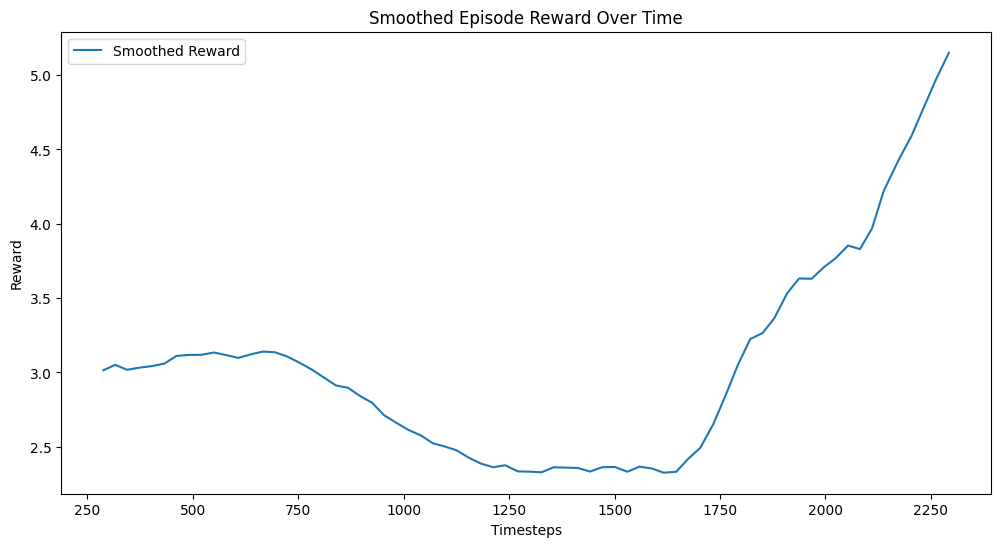

In [85]:
%matplotlib inline
plt.figure(figsize=(12, 6))
plt.plot(logs["timesteps"], logs["reward_smooth"], label="Smoothed Reward")
plt.xlabel("Timesteps")
plt.ylabel("Reward")
plt.title("Smoothed Episode Reward Over Time")
plt.legend()
plt.show()

In [86]:
obs = vec_env.reset()
vec_env.envs[0].unwrapped.episode = 0 # Prints episode info
overall_reward = 0 # Keep track of accumulated overall reward

portfolio_values = []
timesteps = []

i = 0
while True:
    action, _states = model.predict(obs, deterministic=True)
    obs, rewards, done, info = vec_env.step(action)

    if done[0]:
        break

    portfolio_value = vec_env.envs[0].unwrapped.asset_memory[-1]
    portfolio_values.append(portfolio_value)
    timesteps.append(i)
    i += 1

day: 2515, episode: 0
begin_total_asset: 10000.00
end_total_asset: 69259.10
total_reward: 59259.10
total_cost: 8306.27
total_trades: 5520
Sharpe: 0.878


In [ ]:
%matplotlib inline
plt.figure(figsize=(12, 6))
plt.plot(timesteps, portfolio_values, label="Portfolio Value", color='blue')
plt.xlabel("Time Steps")
plt.ylabel("Portfolio Value ($)")
plt.title("RL Model Performance")
plt.legend()
plt.grid()
plt.show()

In [88]:
model.save(input())